In [1]:
import tqdm.notebook as tqdm
import numpy as np
import matplotlib.pyplot as plt

import jax
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp
import jax.random as jrandom

import diffrax
import equinox as eqx
import optax

In [2]:
SEED = 12345
rng = np.random.default_rng(seed=SEED)
key = jrandom.PRNGKey(seed=rng.integers(2**32))

In [3]:
def lotka_volterra(t, y, args):
    alpha = args['alpha']
    beta = args['beta']
    delta = args['delta']
    gamma = args['gamma']
    return jnp.array([
        alpha * y[0] - beta * y[0] * y[1], 
        -delta * y[1] + gamma * y[0] * y[1], 
    ])

In [4]:
def get_sample_data(y0, n, t0, t1, parameters, noise_level, key):
    ts_save = jnp.linspace(t0, t1, n, endpoint=True)
    rhs = diffrax.ODETerm(lotka_volterra)
    sol = diffrax.diffeqsolve(
        rhs, 
        solver=diffrax.Tsit5(),
        t0=t0,
        t1=t1,
        y0=y0,
        args=parameters,
        dt0=1e-3,
        stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-5),
        saveat=diffrax.SaveAt(ts=ts_save),
    )
    
    key, subkey = jrandom.split(key, 2)
    noise = sol.ys * noise_level * jrandom.normal(subkey, shape=sol.ys.shape)

    return sol.ts, sol.ys + noise

In [5]:
tfin = 6.
noise_level = 0.10

nsamples = 1 + int(tfin * 2 / 0.1)
y0 = jnp.ones(shape=2, dtype=jnp.float64)  # initial condition for sample data

lv_args = {
    'alpha': 1.5,
    'beta': 1.0,
    'delta': 3.0,
    'gamma': 1.0,
}


# Generate the data
key, subkey = jrandom.split(key, 2)
ts_data, ys_data = get_sample_data(
    y0, 
    n=nsamples*2, 
    t0=0.0,
    t1=tfin*2, 
    parameters=lv_args, 
    noise_level=noise_level, 
    key=subkey
)

# Split into training and testing sets
ts_train = ts_data[ts_data < tfin]
ys_train = ys_data[ts_data < tfin]

ts_test = ts_data[ts_data >= tfin]
ys_test = ys_data[ts_data >= tfin]

# Solve the LV system exactly
ts_exact, ys_exact = get_sample_data(
    y0, 
    n=nsamples*2, 
    t0=0.0,
    t1=tfin*2, 
    parameters=lv_args, 
    noise_level=0., 
    key=subkey
)

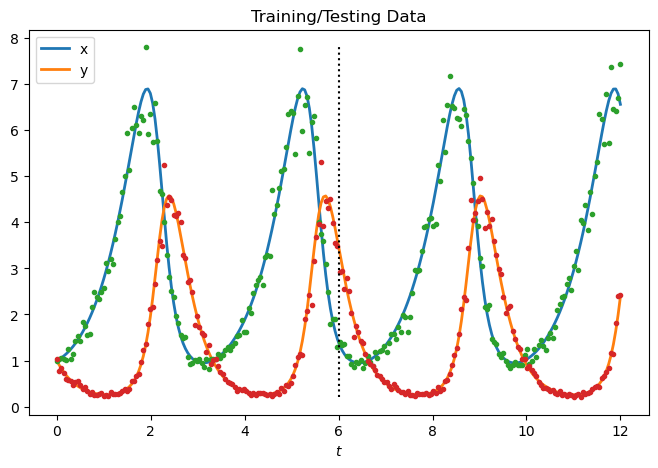

In [6]:
# Plotting the exact solution and the generated data

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

lines = ax.plot(
    ts_exact, ys_exact, '-',
    linewidth=2, 
    label=['x', 'y']
)

ax.plot(
    ts_data, ys_data, '.'
)

ax.vlines(tfin, np.min(ys_data), np.max(ys_data), linestyles=':', colors='k')

ax.set_xlabel("$t$")
ax.legend();
ax.set_title("Training/Testing Data");

## Construct a Model: A simple Neural Network

In [7]:
key, subkey = jrandom.split(key, 2)

model = eqx.nn.MLP(
    in_size=2,
    out_size=2,
    width_size=8,
    depth=4,
    activation=jax.nn.softplus,
    key=subkey,
)

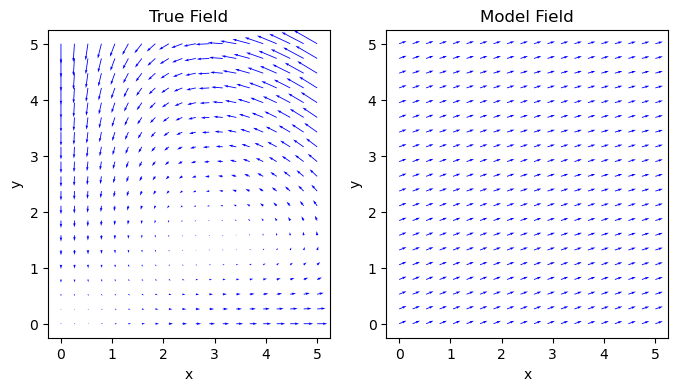

In [8]:
# Plot the true vector field defined by the LV equations, and the vector field
# defined by the (currently untrained) model.

fig, axes = plt.subplots(1, 2, figsize=(8,4))

# Define the grid
x = np.linspace(0, 5, 20)
y = np.linspace(0, 5, 20)
xs, ys = np.meshgrid(x, y)
zs = jnp.array([xs.flatten(), ys.flatten()]).T


# Plot the true vector field
ax = axes[0]
fs = jax.vmap(lambda y: lotka_volterra(0., y, lv_args))(zs)
us = fs[:,0].reshape(xs.shape)
vs = fs[:,1].reshape(ys.shape)
ax.quiver(xs, ys, us, vs, color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True Field')


# Plot the inferred vector field
ax = axes[1]
fs = jax.vmap(model)(zs)
us = fs[:,0].reshape(xs.shape)
vs = fs[:,1].reshape(ys.shape)
ax.quiver(xs, ys, us, vs, color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Model Field');

In [9]:
def get_trajectory(
        model, 
        t0,
        y0,
        t1,
        ts_save,
):
    def rhs(t, y, args):
        return model(y)
    
    rhs = diffrax.ODETerm(rhs)
    sol = diffrax.diffeqsolve(
        rhs, 
        solver=diffrax.Tsit5(),
        t0=t0,
        t1=t1,
        y0=y0,
        dt0=1e-3,
        stepsize_controller=diffrax.PIDController(rtol=1e-4, atol=1e-5),
        saveat=diffrax.SaveAt(ts=ts_save),
    )
    return sol.ts, sol.ys


def euclidean_loss(ys_pred, ys_act):
    return jnp.mean(jnp.sum(jnp.square(ys_pred - ys_act), axis=1))


# This decorator causes the function to return both the return value, and the
# derivative of the returned value with respect to any arrays in the first 
# argument, in this case the arrays of `model`.
@eqx.filter_value_and_grad
def compute_loss(model, t0, y0, t1, y1_act, ts_save, loss_function):
    _, ys_pred = get_trajectory(model, t0, y0, t1, ts_save)
    loss = loss_function(ys_pred, y1_act)
    return loss


# This decorator just makes things fast.
@eqx.filter_jit
def make_step(
        model, optim, opt_state, 
        t0, y0, t1, y1_act, 
        ts_save, 
        loss_function
):
    loss, grads = compute_loss(
        model, t0, y0, t1, y1_act, ts_save, loss_function
    )
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss


@eqx.filter_jit    
def test_step(model, t0, y0, t1, y1_act, ts_save, loss_function):
    _, y1_pred = get_trajectory(
        model, t0, y0, t1, ts_save
    )
    return loss_function(y1_pred, y1_act)

In [10]:
best_model = model
best_loss = np.inf

  0%|          | 0/8000 [00:00<?, ?it/s]

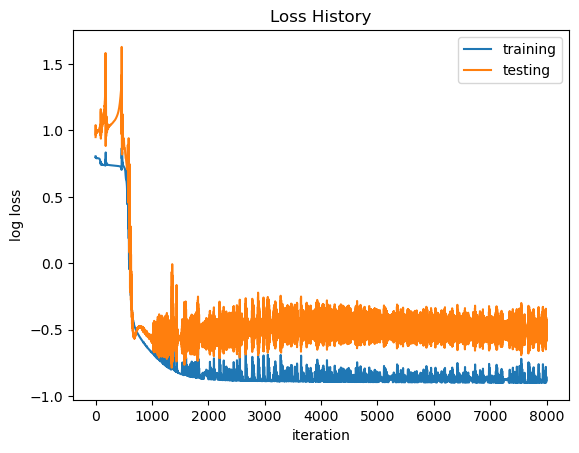

In [11]:
nsteps = 2000
learning_rate = 1e-2

optim = optax.adamw(learning_rate=learning_rate)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

train_losses = np.zeros(nsteps)
test_losses = np.zeros(nsteps)

for i in tqdm.trange(nsteps):
    key, subkey1, subkey2 = jrandom.split(key, 3)

    # Training Step
    model, opt_state, train_loss = make_step(
        model, optim, opt_state, 
        ts_train[0], 
        ys_train[0],
        ts_train[-1], 
        ys_train, 
        ts_train, 
        euclidean_loss
    )
    train_losses[i] = train_loss
    
    # Testing Step
    test_loss = test_step(
        model, 
        ts_test[0], 
        ys_test[0],
        ts_test[-1], 
        ys_test,
        ts_test,
        euclidean_loss
    )
    test_losses[i] = test_loss
    if test_loss < best_loss:
        best_loss = test_loss
        best_model = model


model = best_model

plt.plot(np.log10(train_losses), label='training')
plt.plot(np.log10(test_losses), label='testing')
plt.legend()
plt.xlabel("iteration")
plt.ylabel("log loss")
plt.title("Loss History");


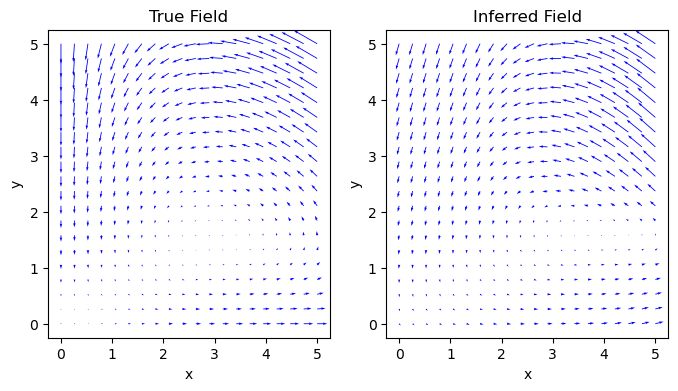

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(8,4))

# Define the grid
x = np.linspace(0, 5, 20)
y = np.linspace(0, 5, 20)
xs, ys = np.meshgrid(x, y)
zs = jnp.array([xs.flatten(), ys.flatten()]).T


# Plot the true vector field
ax = axes[0]
fs = jax.vmap(lambda y: lotka_volterra(0., y, lv_args))(zs)
us = fs[:,0].reshape(xs.shape)
vs = fs[:,1].reshape(ys.shape)
ax.quiver(xs, ys, us, vs, color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('True Field')


# Plot the inferred vector field
ax = axes[1]
fs = jax.vmap(model)(zs)
us = fs[:,0].reshape(xs.shape)
vs = fs[:,1].reshape(ys.shape)
ax.quiver(xs, ys, us, vs, color='b')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Inferred Field');

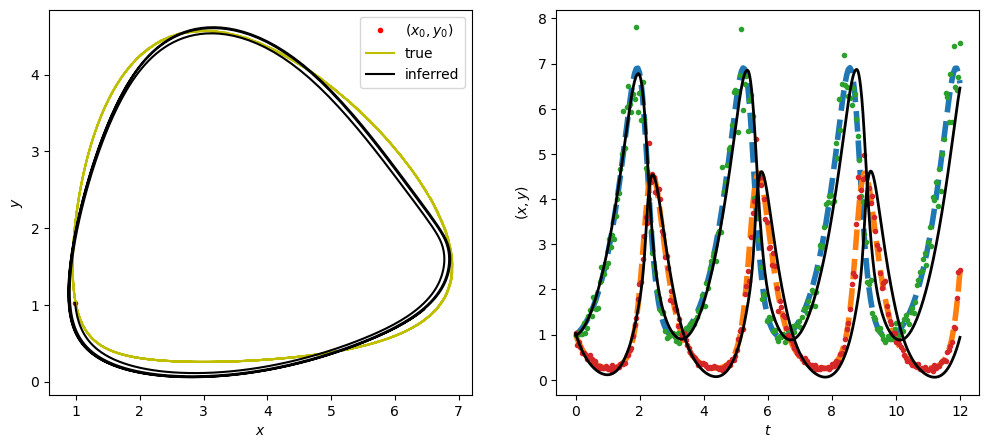

In [13]:
ts_samp, ys_samp = get_trajectory(
    model, ts_data[0], ys_data[0], 
    t1=ts_test[-1], ts_save=jnp.linspace(0., ts_test[-1], 1000)
)

fig, axes = plt.subplots(1, 2, figsize=(12,5))


ax = axes[0]
ax.plot(
    ys_samp[0,0], ys_samp[0,1], 'r.', label='$(x_0, y_0)$'
)
ax.plot(
    ys_exact[:,0], ys_exact[:,1], 'y-', label='true'
)
ax.plot(
    ys_samp[:,0], ys_samp[:,1], 'k', label='inferred'
)
ax.legend()
ax.set_xlabel("$x$")
ax.set_ylabel("$y$")


ax = axes[1]
lines = ax.plot(
    ts_exact, ys_exact, '--', linewidth=4
)

for i in range(2):
    ax.plot(
        ts_data, ys_data[:,i], '.', 
    )

ax.plot(
    ts_samp, ys_samp, 'k-', linewidth=2
)

ax.set_xlabel("$t$")
ax.set_ylabel("$(x,y)$");